# Solving Maximum Independent Set using QAOA and ZNE

We now know that noise affects the performance of the variational algorithms adversely. Given that the variational algorithms we consider are hailed as _NISQ-era quantum algorithms_, it is important for us to figure out how we can enhance the performance of these algorithms in the presence of noise. One way to perform this enhancement is through __Error Mitigation__. 

Error mitigation is the process of obtaining data from quantum experiments and classically post-processing it to obtain a result that would correspond to a result from an ideal noiseless quantum system. Depending on the types of noises considered, there are various error mitigation techniques present in the literature. In this notebook, we will consider a well-known error mitigation technique called __Zero Noise Extrapolation (ZNE)__.

Many times, especially when using the variational algorithms, one is interested in estimating the expectation value of an observable with respect to a state of interest. In our case, we are interested in obtaining the ground state energy of the graph Hamiltonian, i.e., the expectation value of the graph Hamiltonian with respect to its ground state. However, under the influence of noise, one gets an estimate that is possibly different from the actual ground state energy. The higher the noise, the farther the estimate from the ground state energy, but the extent of noise is related to the estimated expectation value. The idea of ZNE is to exploit this relation between the extent of noise and the estimated expectation value to extrapolate it to the case of no noise. In ZNE, we increase the extent of the noise systematically and obtain the corresponding expectation values. These values are then used to extrapolate to obtain the expectation value under no noise.

More mathematically, let $\lambda$ be a scaling factor and $E(\lambda)$ be a function that returns the expectation value when the noise is scaled by a factor of $\lambda$. We define $E(1)$ as the expectation value estimated from the actual quantum circuit (or, ansatz in our case) under the influence of noise. The goal is to obtain $E(0)$, which corresponds to the expectation value of the observation when there is no noise. Obtaining this using ZNE consists of two steps:
1. _Step 1_: Noise Scaling
In this step, we obtain the estimates of $E(\lambda)$ for multiple values of $\lambda\ge 1$.

2. _Step 2_: Extrapolation
In this step, we use the estimates obtained in Step 1 and extrapolate $E$ to obtain $E(0)$.

#### Noise Scaling:
Noise scaling can be performed in different ways for different types of circuits. In our case, where we use gate-based circuits, there are two main ways to scale the noise, namely (i) Circuit folding and (ii) Gate folding.
##### (i) Circuit Folding:
Let $U$ be a unitary circuit that is used to obtain the expectation value of an observable, and let $\lambda$ be a scaling factor. The idea behind the circuit folding technique is to first apply $U$ followed by repeated applications of the circuit block $U^\dagger U$ multiple times to increase the depth of the circuit. Note that the circuit block $U^\dagger U$ logically corresponds to the identity operator $I$. However, since the noise plays its part, each application of $U^\dagger U$ scales up the noise. In fact, $k$ applications of $U^\dagger U$ scales up the noise from $1$ to a factor of $2k_1$. So, the circuit folding technique involves performing the replacement mapping $U \rightarrow U(U^\dagger U)^k$, where $k = \lambda/2$.
##### (ii) Gate Folding:
Another way to scale up the noise in the circuit is to add repetition that corresponds to a logical identity at the gate level. Let $U = L_d\cdots L_2L_1$ be the circuit under consideration, where $L_i$ is the $i^{th}$ layer of the circuit. Then the gate folding technique involves performing the replacement mapping $U \rightarrow L_d(L_d^\dagger L_d)^k\cdots L_2(L_2^\dagger L_2)^kL_2(L_1^\dagger L_1)^k$, where $k = \lambda/2$. Again, note that each $(L_i^\dagger L_i)$ block is a logical identity.

#### Extrapolation:
Once we have the estimates of $E(\lambda)$ for a set of $\lambda\ge 1$, we can use those values to fit it to a function. However, in this case, we do not have any idea about how the function $E(\lambda)$ might look like. So, we assume that the $E$ function is one of the linear, quadratic, and exponential functions. In this notebook, we use the scipy _curve_fit_ function to fit the obtained expectation values, and extrapolate them to $0$.


In this notebook, we will explore how ZNE can be used to mitigate noise when using QAOA to solve the MIS problem.

### Importing required functions

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import SparsePauliOp
from qiskit.primitives import BackendEstimatorV2 as Estimator

import rustworkx as rx
import numpy as np
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

from src.graph_gen import *
from src.hamiltonian_gen import get_hamiltonian_from_graph
from src.helper_functions import top_k_counts, exptrapolate_for_zero

In [3]:
from src.bfminimize import BFMinimizeCombinatorial
from src.qaoa import QAOA
from src.adaptqaoa import AdaptQAOA
from src.vqe import VQE
from src.dcqaoa import DCQAOA

from src.mitigation_functions import circuit_folding, gate_folding

#### Graph Generation and Brute Force Optimization

In [4]:
num_instances = 5
graph_instances = []
graph_hamiltonians = []

for i in range(num_instances):
    graph = generate_random_graph(5, 0.4)
    graph_instances.append(graph)
    cost_hamiltonian = get_hamiltonian_from_graph(graph)
    graph_hamiltonians.append(cost_hamiltonian)

In [5]:
brute_optimal_cost = []
for hamiltonian in graph_hamiltonians:
    brute = BFMinimizeCombinatorial(hamiltonian)
    brute.run()
    brute_optimal_cost.append(brute.optimal_value)

avg_brute_optimal_cost = sum(brute_optimal_cost)/num_instances

#### Importing the noise parameters of 'ibm_torino' backend

In [6]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
torino_backend = service.backend('ibm_torino')

noisy_backend = AerSimulator.from_backend(torino_backend)
noiseless_backend = AerSimulator()

estimator = Estimator(backend = noisy_backend)
pm = generate_preset_pass_manager(backend = noisy_backend, optimization_level = 0)

In [7]:
repetitions = 3

#### QAOA

In [8]:
# Noiseless Simulation

qaoa_noiseless_insts = []
qaoa_noiseless_optimal_cost = []

for idx, hamiltonian in enumerate(graph_hamiltonians):
    print(f"Solving for Graph #{idx+1}.")
    qaoa = QAOA(hamiltonian, num_layers = repetitions, backend = noiseless_backend)
    qaoa.run()
    qaoa_noiseless_optimal_cost.append(qaoa.optimal_value)
    qaoa_noiseless_insts.append(qaoa)

Solving for Graph #1.
Solving for Graph #2.
Solving for Graph #3.
Solving for Graph #4.
Solving for Graph #5.


In [9]:
avg_qaoa_noiselss_optimal_cost = sum(qaoa_noiseless_optimal_cost)/num_instances
avg_qaoa_noiseless_error = np.abs(avg_brute_optimal_cost -avg_qaoa_noiselss_optimal_cost)

In [10]:
qaoa_optimal_ansatz = [qaoa_inst.ansatz.copy().assign_parameters(qaoa_inst.optimal_parameters) for qaoa_inst in qaoa_noiseless_insts]

To perform the noisy simulation, we obtain the optimal ansatz and the optimal parameters of the QAOA instance and separately simulate them in the noisy backend. Although one might think of simply replacing the noiseless backend with a noisy backend when solving the MIS problem, due to the randomized nature of the classical optimization functions, one is not guaranteed to obtain the same ansatz and optimal parameters. So, replacing the backend in the QAOA instance might not be the right way to compare the noisy and the noiseless settings when investigating the use of error mitigation.

In [11]:
qaoa_noisy_optimal_cost = []

for opt_ansatz, hamiltonian in zip(qaoa_optimal_ansatz, graph_hamiltonians):
    transpiled_opt_ansatz = pm.run(opt_ansatz)
    mapped_hamiltonian = hamiltonian.apply_layout(transpiled_opt_ansatz.layout)
    cost = estimator.run([(transpiled_opt_ansatz, mapped_hamiltonian)]).result()[0].data.evs
    qaoa_noisy_optimal_cost.append(cost)

In [12]:
avg_qaoa_noisy_optimal_cost = sum(qaoa_noisy_optimal_cost)/num_instances
avg_qaoa_noisy_error = np.abs(avg_brute_optimal_cost -avg_qaoa_noisy_optimal_cost)

In [13]:
print(f"The average error in the noiseless simulation is {avg_qaoa_noiseless_error}.")
print(f"The average error in the noisy simulation is {avg_qaoa_noisy_error}.")

The average error in the noiseless simulation is 3.0426269531249996.
The average error in the noisy simulation is 4.194384765624999.


#### Mitigating Error Using Circuit Folding

First, we will use the circuit folding technique to scale up the noise in the circuit.

In [14]:
circuit_folded_ansatz_qaoa = []
scaling_list = [1, 2, 4, 6, 8, 10, 12]
for optimal_ansatz in qaoa_optimal_ansatz:
    circuit_folded_ansatz_qaoa.append([])
    for scaling_factor in scaling_list:
        circuit_folded_ansatz_qaoa[-1].append(circuit_folding(optimal_ansatz, scaling_factor))

In [15]:
costs_scaled_qaoa = []

for circ_arr, hamiltonian in zip(circuit_folded_ansatz_qaoa, graph_hamiltonians):
    costs_scaled_qaoa.append([])
    for circ in circ_arr:
        transpiled_circ = pm.run(circ)
        mapped_hamiltonian = hamiltonian.apply_layout(transpiled_circ.layout)
        cost = estimator.run([(transpiled_circ, mapped_hamiltonian)]).result()[0].data.evs
        costs_scaled_qaoa[-1].append(cost)

In [16]:
extended_scaling_list = [0] + scaling_list

costs_at_zero_linear_qaoa = []
extrap_fns_linear_qaoa = []
for costs_arr in costs_scaled_qaoa:
    cost, fun = exptrapolate_for_zero(scaling_list, costs_arr, method = 'linear')
    costs_at_zero_linear_qaoa.append(cost)
    extrap_fns_linear_qaoa.append(fun)

costs_at_zero_quadratic_qaoa = []
extrap_fns_quadratic_qaoa = []
for costs_arr in costs_scaled_qaoa:
    cost, fun = exptrapolate_for_zero(scaling_list, costs_arr, method = 'quadratic')
    costs_at_zero_quadratic_qaoa.append(cost)
    extrap_fns_quadratic_qaoa.append(fun)

costs_at_zero_exp_qaoa = []
extrap_fns_exp_qaoa = []
for costs_arr in costs_scaled_qaoa:
    cost, fun = exptrapolate_for_zero(scaling_list, costs_arr, method = 'exp')
    costs_at_zero_exp_qaoa.append(cost)
    extrap_fns_exp_qaoa.append(fun)

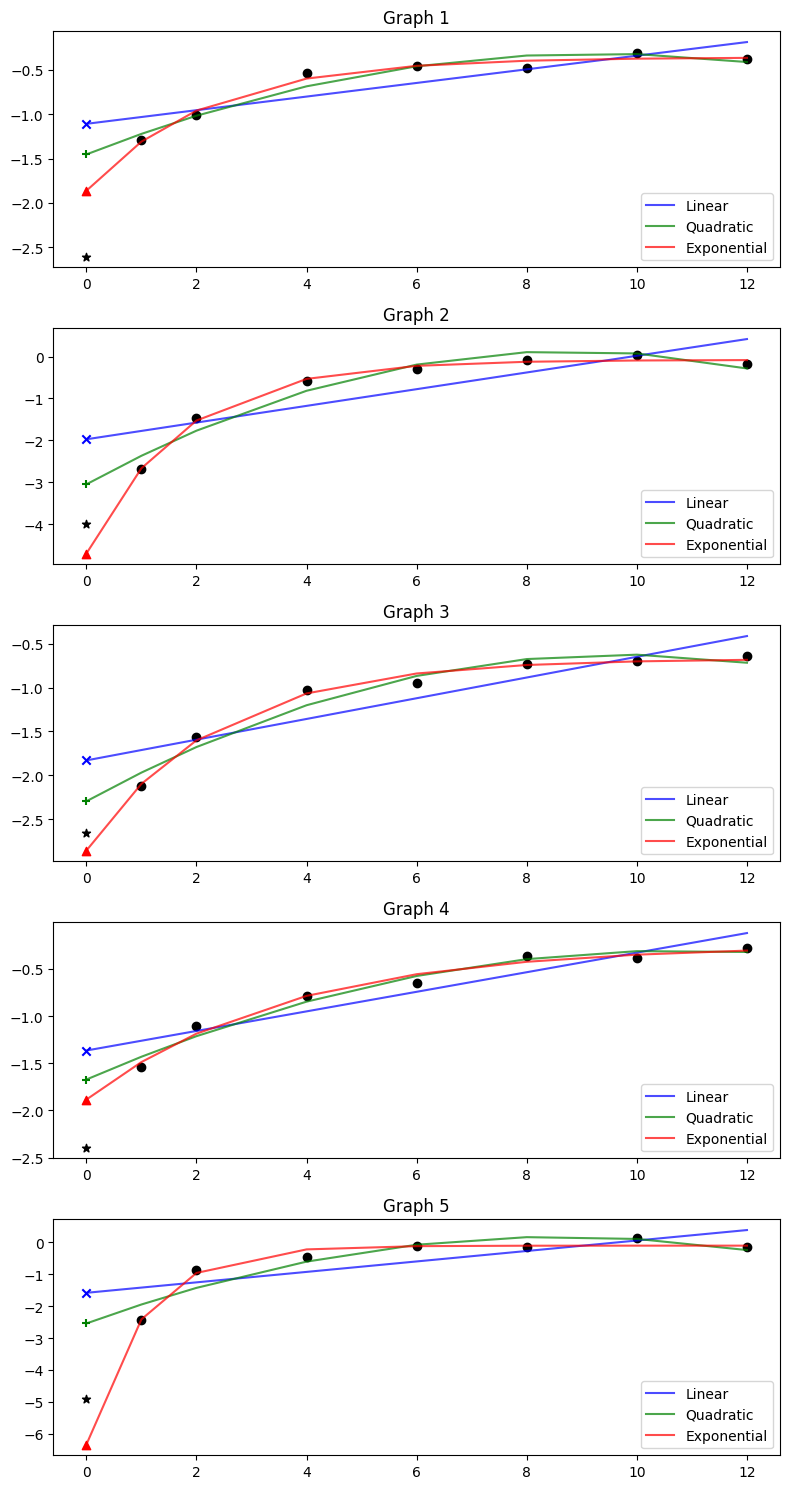

In [17]:
fig, axs = plt.subplots(5, 1, figsize=(8, 15))

for idx in range(num_instances):
    axs[idx].scatter(scaling_list, costs_scaled_qaoa[idx], color = 'k')
    axs[idx].scatter([0], costs_at_zero_linear_qaoa[idx], marker = 'x', color = 'b')
    axs[idx].scatter([0], costs_at_zero_quadratic_qaoa[idx], marker = '+', color = 'g')
    axs[idx].scatter([0], costs_at_zero_exp_qaoa[idx], marker = '^', color = 'r')
    axs[idx].scatter([0], qaoa_noiseless_optimal_cost[idx], marker = '*', color = 'k')
    axs[idx].plot(extended_scaling_list, [extrap_fns_linear_qaoa[idx](x) for x in extended_scaling_list], color = 'b', alpha=0.7, label = 'Linear')
    axs[idx].plot(extended_scaling_list, [extrap_fns_quadratic_qaoa[idx](x) for x in extended_scaling_list], color = 'g', alpha=0.7, label = 'Quadratic')
    axs[idx].plot(extended_scaling_list, [extrap_fns_exp_qaoa[idx](x) for x in extended_scaling_list], color = 'r', alpha=0.7, label = 'Exponential')
    axs[idx].legend(loc='lower right')
    axs[idx].set_title(f'Graph {idx+1}')


plt.tight_layout()
plt.show()

We can see that in most of the cases, the extrapolation using the exponential function offer a expectation value to the noiseless optimal value (the value marked by the black star). In certain cases, even the extrapolation using the quadratic function is close by.

#### Mitigating Error Using Gate Folding

Now, we use the gate folding technique to scale up the noise in the circuit.

In [18]:
gate_folded_ansatz_qaoa = []
scaling_list = [1, 2, 4, 6, 8, 10, 12]
for optimal_ansatz in qaoa_optimal_ansatz:
    gate_folded_ansatz_qaoa.append([])
    for scaling_factor in scaling_list:
        gate_folded_ansatz_qaoa[-1].append(gate_folding(optimal_ansatz, scaling_factor))

In [19]:
costs_scaled_qaoa = []

for circ_arr, hamiltonian in zip(gate_folded_ansatz_qaoa, graph_hamiltonians):
    costs_scaled_qaoa.append([])
    for circ in circ_arr:
        transpiled_circ = pm.run(circ)
        mapped_hamiltonian = hamiltonian.apply_layout(transpiled_circ.layout)
        cost = estimator.run([(transpiled_circ, mapped_hamiltonian)]).result()[0].data.evs
        costs_scaled_qaoa[-1].append(cost)

In [23]:
extended_scaling_list = [0] + scaling_list

costs_at_zero_linear_qaoa = []
extrap_fns_linear_qaoa = []
for costs_arr in costs_scaled_qaoa:
    cost, fun = exptrapolate_for_zero(scaling_list, costs_arr, method = 'linear')
    costs_at_zero_linear_qaoa.append(cost)
    extrap_fns_linear_qaoa.append(fun)

costs_at_zero_quadratic_qaoa = []
extrap_fns_quadratic_qaoa = []
for costs_arr in costs_scaled_qaoa:
    cost, fun = exptrapolate_for_zero(scaling_list, costs_arr, method = 'quadratic')
    costs_at_zero_quadratic_qaoa.append(cost)
    extrap_fns_quadratic_qaoa.append(fun)

costs_at_zero_exp_qaoa = []
extrap_fns_exp_qaoa = []
for costs_arr in costs_scaled_qaoa:
    cost, fun = exptrapolate_for_zero(scaling_list, costs_arr, method = 'exp')
    costs_at_zero_exp_qaoa.append(cost)
    extrap_fns_exp_qaoa.append(fun)

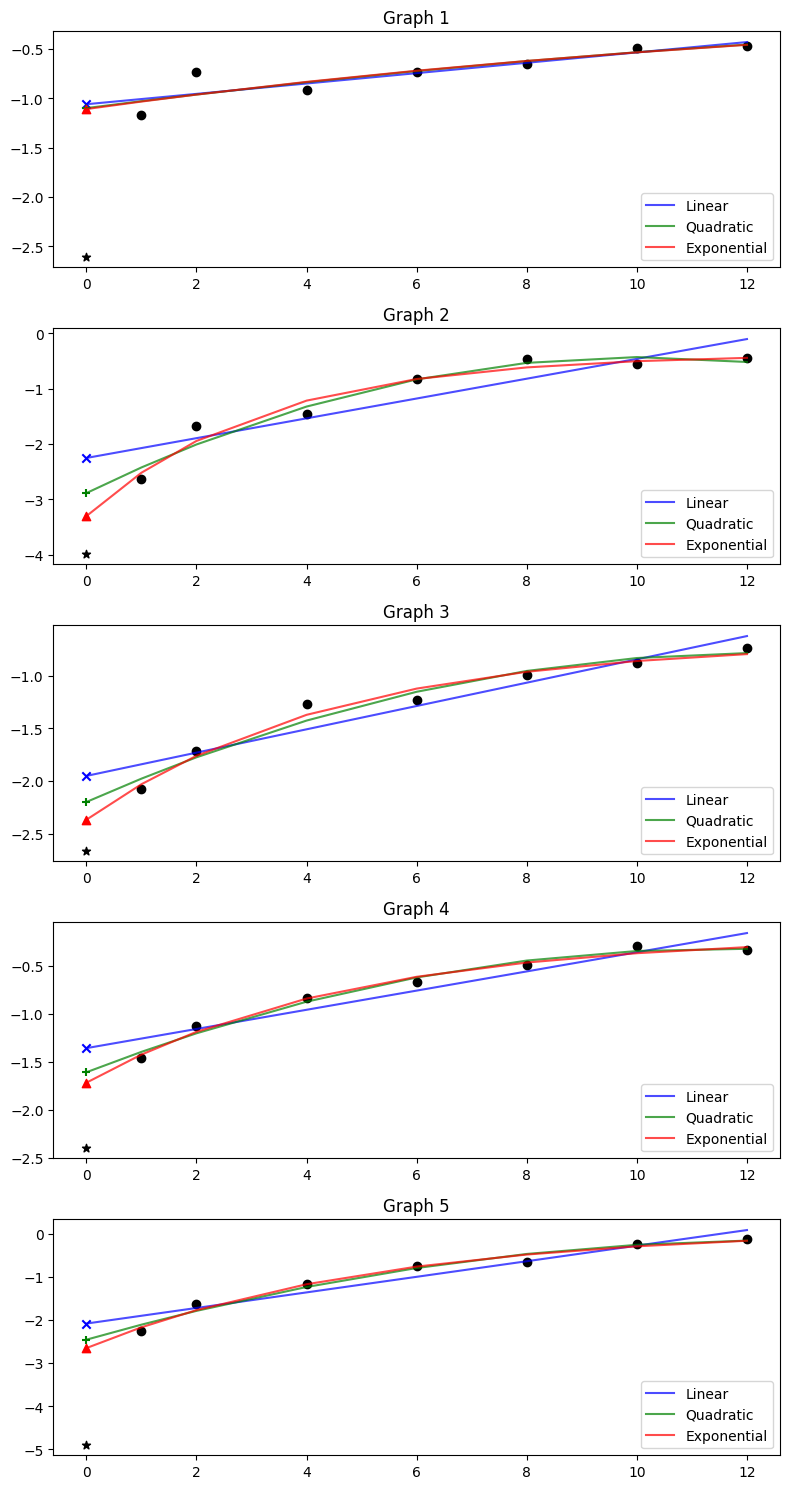

In [24]:
fig, axs = plt.subplots(5, 1, figsize=(8, 15))

for idx in range(num_instances):
    axs[idx].scatter(scaling_list, costs_scaled_qaoa[idx], color = 'k')
    axs[idx].scatter([0], costs_at_zero_linear_qaoa[idx], marker = 'x', color = 'b')
    axs[idx].scatter([0], costs_at_zero_quadratic_qaoa[idx], marker = '+', color = 'g')
    axs[idx].scatter([0], costs_at_zero_exp_qaoa[idx], marker = '^', color = 'r')
    axs[idx].scatter([0], qaoa_noiseless_optimal_cost[idx], marker = '*', color = 'k')
    axs[idx].plot(extended_scaling_list, [extrap_fns_linear_qaoa[idx](x) for x in extended_scaling_list], color = 'b', alpha=0.7, label = 'Linear')
    axs[idx].plot(extended_scaling_list, [extrap_fns_quadratic_qaoa[idx](x) for x in extended_scaling_list], color = 'g', alpha=0.7, label = 'Quadratic')
    axs[idx].plot(extended_scaling_list, [extrap_fns_exp_qaoa[idx](x) for x in extended_scaling_list], color = 'r', alpha=0.7, label = 'Exponential')
    axs[idx].legend(loc='lower right')
    axs[idx].set_title(f'Graph {idx+1}')


plt.tight_layout()
plt.show()

When the gate folding technique is used, the curve fits are different from that of the circuit folding. Again, extrapolation using the exponential function offers a closer expectation value to the noiseless expectation value that quadratic or linear, although all three are relatively far away from the noiseless expectaion.

It would be interesting to understand the scenarios when the gate folding offers an advantage over the circuit folding technique and vice-versa. One further interesting direction of research is to investigate if an educate guess on the form of the function $E$ can be made based on the problem to be solved. This will allow us to obtain a more closer and accurate estimate of the expectation value of the observable that a simply assuming it to be some general form.

In the latter notebooks, we will use the ZNE technique on other variational algorithms.